In [1]:
# Modules will be reloaded every time a cell is executed
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn import utils
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import HistGradientBoostingRegressor, GradientBoostingRegressor

from funmirtar.models.constants import SEEDS_TO_COUNT, SEED_COUNT_COLUMNS, GLOBAL_FEATURES, LOCAL_FEATURES, REGRESSION_COLUMNS
from funmirtar.utils.plots import plot_correlation, plot_multiple_cdfs_with_medians, plot_two_correlations
from funmirtar.utils.file import make_dir_with_parents

In [3]:
utils.check_random_state(3)
np.random.seed(1)

In [4]:
RUN_NAME = 'seeds.signal.local_features'
# RUN_NAME = 'seeds.signal'
# RUN_NAME = 'seeds'

In [5]:
MODEL_LIST = [
    f'logistic_regression.{RUN_NAME}',
    f'gradient_boosting_classifier.{RUN_NAME}',
    f'xgb.{RUN_NAME}',
    f'random_forest.{RUN_NAME}',    
]

OUT_COLUMNS = []
OUT_COLUMNS.extend(REGRESSION_COLUMNS)
OUT_COLUMNS.extend(MODEL_LIST)

In [6]:
COLUMNS_FOR_PRED = []
COLUMNS_FOR_PRED.extend(GLOBAL_FEATURES)
COLUMNS_FOR_PRED.extend(LOCAL_FEATURES)
COLUMNS_FOR_PRED.extend(SEEDS_TO_COUNT)
COLUMNS_FOR_PRED.extend(SEED_COUNT_COLUMNS)
# COLUMNS_FOR_PRED.remove('kmer6_bulge_or_mismatch_count')

In [7]:
IN_FOLDER_PATH = "../data/preprocessed_for_ml/"

# FILE_PATH = '3utr.sequences.refseq_id.mirna_fc.seed_cls.sequence.signal.conservation.seed_cls.ts_preds'
FILE_PATH = '3utr.sequences.refseq_id.mirna_fc.seed_cls.sequence.signal.conservation.seed_cls.ts_preds.local_features'

IN_FEATURES_PATH_TRAIN = Path(
    IN_FOLDER_PATH + FILE_PATH + '.train.pkl'
)
IN_FEATURES_PATH_TEST = Path(
    IN_FOLDER_PATH + FILE_PATH + '.test.pkl'
)

IN_FEATURES_PATH_TRAIN, IN_FEATURES_PATH_TEST

(PosixPath('../data/preprocessed_for_ml/3utr.sequences.refseq_id.mirna_fc.seed_cls.sequence.signal.conservation.seed_cls.ts_preds.local_features.train.pkl'),
 PosixPath('../data/preprocessed_for_ml/3utr.sequences.refseq_id.mirna_fc.seed_cls.sequence.signal.conservation.seed_cls.ts_preds.local_features.test.pkl'))

In [8]:
OUT_FOLDER_PATH = f"../data/predictions/{RUN_NAME}/"

PREDICTION_TYPE = '.regression_preds'

OUT_PATH_TRAIN = Path(
    OUT_FOLDER_PATH + FILE_PATH + PREDICTION_TYPE + '.train.pkl'
)
OUT_PATH_TEST = Path(
    OUT_FOLDER_PATH + FILE_PATH + PREDICTION_TYPE + '.test.pkl'
)
OUT_PATH_TRAIN, OUT_PATH_TEST

(PosixPath('../data/predictions/seeds.signal.local_features/3utr.sequences.refseq_id.mirna_fc.seed_cls.sequence.signal.conservation.seed_cls.ts_preds.local_features.regression_preds.train.pkl'),
 PosixPath('../data/predictions/seeds.signal.local_features/3utr.sequences.refseq_id.mirna_fc.seed_cls.sequence.signal.conservation.seed_cls.ts_preds.local_features.regression_preds.test.pkl'))

In [9]:
make_dir_with_parents(OUT_FOLDER_PATH)

PosixPath('../data/predictions/seeds.signal.local_features')

In [10]:
data_train = pd.read_pickle(IN_FEATURES_PATH_TRAIN)
data_test = pd.read_pickle(IN_FEATURES_PATH_TEST)

In [11]:
# HOTFIX until we regenerate new data file with corrected naming
data_train.rename(columns={'kmer6_mismatch_count':'kmer6_bulge_or_mismatch_count'}, inplace=True)
data_test.rename(columns={'kmer6_mismatch_count':'kmer6_bulge_or_mismatch_count'}, inplace=True)

In [12]:
x_train = data_train[COLUMNS_FOR_PRED].fillna(0,inplace=False)
x_test = data_test[COLUMNS_FOR_PRED].fillna(0,inplace=False)

In [13]:
def positive_values_to_zero(values):
    return [x if x<0 else 0 for x in values]

In [14]:
# y_train = data_train.fold_change
# y_test = data_test.fold_change

y_train = positive_values_to_zero(data_train.fold_change)
y_test = positive_values_to_zero(data_test.fold_change)

In [15]:
# HOTFIX Targetscan predictions with filled NaNs have to be added to a separate prediction file 
# file specifically for target scan
y_targetscan_weighted_test = data_test['label']
y_pred_targetscan_weighted_test = data_test['weighted context++ score percentile'].fillna(0,inplace=False)

y_targetscan_weighted_train = data_train['label']
y_pred_targetscan_weighted_train = data_train['weighted context++ score percentile'].fillna(0,inplace=False)

### Train models

In [16]:
model_lr = LinearRegression()
model_lr.fit(x_train, y_train)

y_pred_lr_test = model_lr.predict(x_test)
y_pred_lr_train = model_lr.predict(x_train)

data_test[f'linear_regression.{RUN_NAME}']=y_pred_lr_test
data_train[f'linear_regression.{RUN_NAME}']=y_pred_lr_train

In [17]:
model_grad = GradientBoostingRegressor()
model_grad.fit(x_train, y_train)

y_pred_grad_test = model_grad.predict(x_test)
y_pred_grad_train = model_grad.predict(x_train)

data_test[f'gradient_boosting_regressor.{RUN_NAME}']=y_pred_grad_test
data_train[f'gradient_boosting_regressor.{RUN_NAME}']=y_pred_grad_train

In [18]:
model_tree = DecisionTreeRegressor()
model_tree.fit(x_train, y_train)

y_pred_tree_test = model_tree.predict(x_test)
y_pred_tree_train = model_tree.predict(x_train)

data_test[f'decision_tree_regressor.{RUN_NAME}']=y_pred_tree_test
data_train[f'decision_tree_regressor.{RUN_NAME}']=y_pred_tree_train

In [19]:
### HOTFIX Train models with different feature set - only for now to quickly get plots 
COLUMNS_FOR_PRED_SEEDS = []
COLUMNS_FOR_PRED_SEEDS.extend(SEEDS_TO_COUNT)
COLUMNS_FOR_PRED_SEEDS.extend(SEED_COUNT_COLUMNS)

In [20]:
x_train_SEEDS = data_train[COLUMNS_FOR_PRED_SEEDS].fillna(0,inplace=False)
x_test_SEEDS = data_test[COLUMNS_FOR_PRED_SEEDS].fillna(0,inplace=False)

model_grad = GradientBoostingRegressor()
model_grad.fit(x_train_SEEDS, y_train)

y_pred_grad_test_SEEDS = model_grad.predict(x_test_SEEDS)
y_pred_grad_train_SEEDS = model_grad.predict(x_train_SEEDS)

data_test[f'gradient_boosting_regressor.seeds']=y_pred_grad_test_SEEDS
data_train[f'gradient_boosting_regressor.seeds']=y_pred_grad_train_SEEDS

In [21]:
### HOTFIX Train models with different feature set - only for now to quickly get plots 
COLUMNS_FOR_PRED_SEEDS_SIGNAL = []
COLUMNS_FOR_PRED_SEEDS_SIGNAL.extend(GLOBAL_FEATURES)
COLUMNS_FOR_PRED_SEEDS_SIGNAL.extend(SEEDS_TO_COUNT)
COLUMNS_FOR_PRED_SEEDS_SIGNAL.extend(SEED_COUNT_COLUMNS)

In [22]:
x_train_SEEDS_SIGNAL = data_train[COLUMNS_FOR_PRED_SEEDS_SIGNAL].fillna(0,inplace=False)
x_test_SEEDS_SIGNAL = data_test[COLUMNS_FOR_PRED_SEEDS_SIGNAL].fillna(0,inplace=False)

model_grad = GradientBoostingRegressor()
model_grad.fit(x_train_SEEDS_SIGNAL, y_train)

y_pred_grad_test_SEEDS_SIGNAL = model_grad.predict(x_test_SEEDS_SIGNAL)
y_pred_grad_train_SEEDS_SIGNAL = model_grad.predict(x_train_SEEDS_SIGNAL)

data_test[f'gradient_boosting_regressor.seeds.signal']=y_pred_grad_test_SEEDS_SIGNAL
data_train[f'gradient_boosting_regressor.seeds.signal']=y_pred_grad_train_SEEDS_SIGNAL

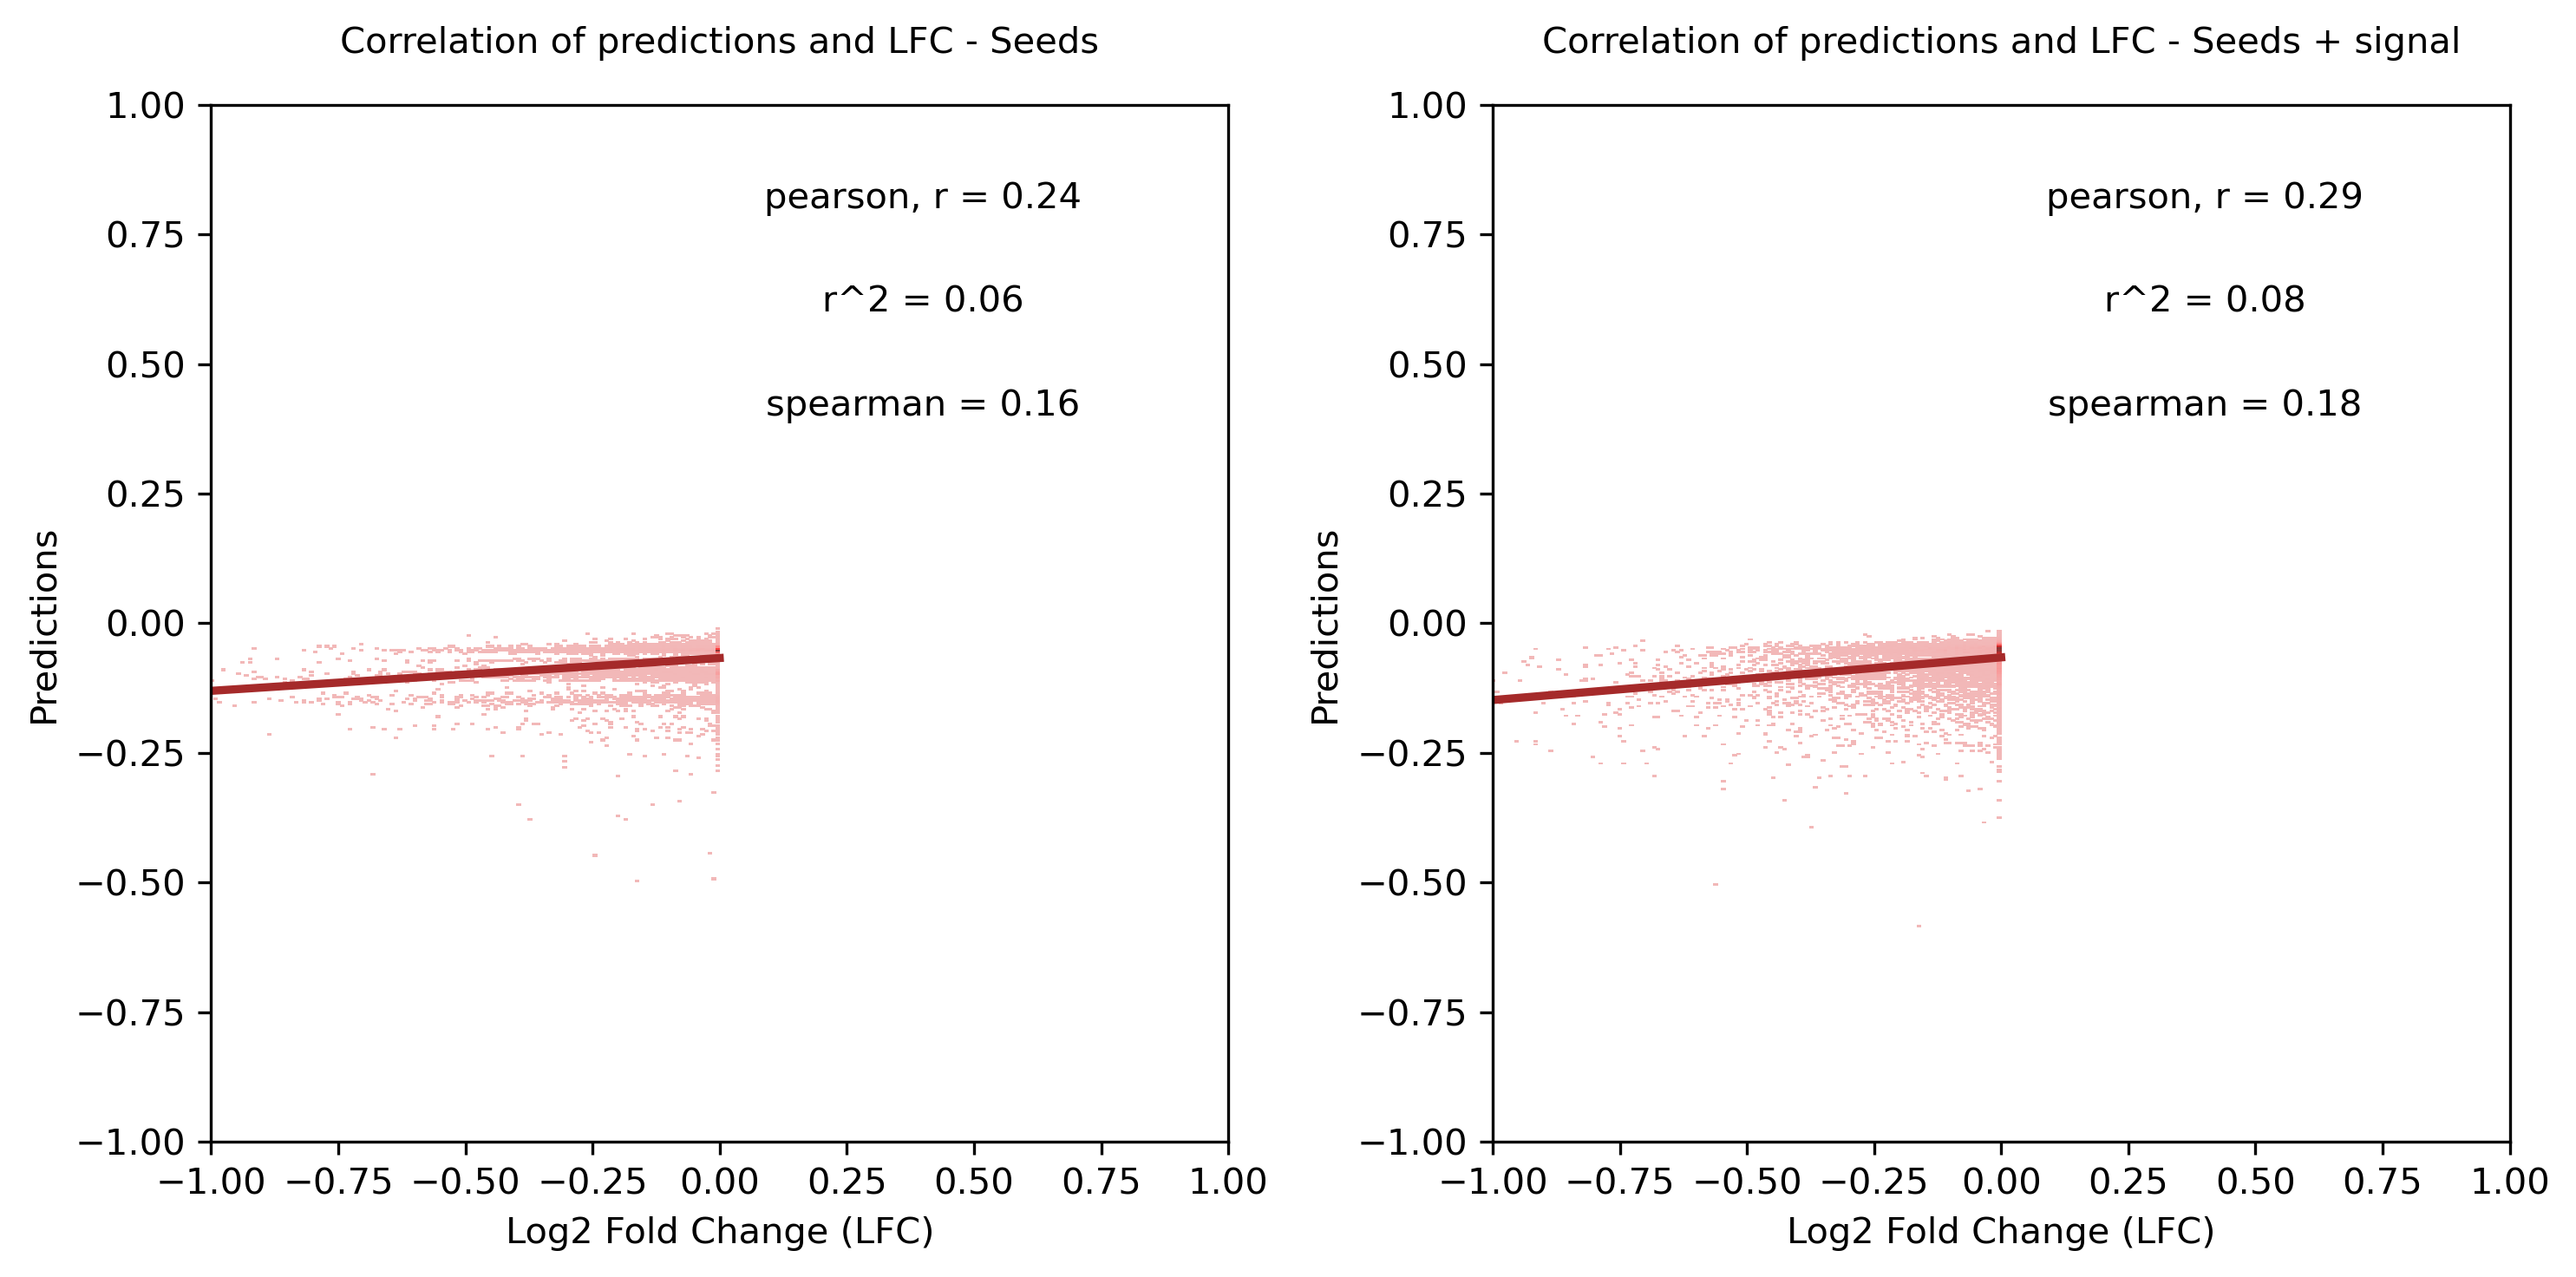

FileNotFoundError: [Errno 2] No such file or directory: 'plots/model_comparison.regression/seeds.seeds_signal_two_correlations.png'

In [23]:
plot_two_correlations(
    positive_values_to_zero(y_test), 
    positive_values_to_zero(y_pred_grad_test_SEEDS), #y_pred_tree_test y_pred_grad_test y_pred_lr_test data_test['weighted context++ score']
    'Seeds', 
    positive_values_to_zero(y_test), 
    positive_values_to_zero(y_pred_grad_test_SEEDS_SIGNAL),
    'Seeds + signal',
    path='plots/model_comparison.regression/seeds.seeds_signal'
)

In [ ]:
plot_two_correlations(
    positive_values_to_zero(y_test), 
    positive_values_to_zero(y_pred_grad_test), #y_pred_tree_test y_pred_grad_test y_pred_lr_test data_test['weighted context++ score']
    'Seeds + signal + local features', 
    positive_values_to_zero(y_test), 
    data_test['weighted context++ score'],
    'TargetScan',
    path='plots/model_comparison.regression/seeds_signal_local_features.targetscan'
)

In [ ]:
# plot_correlation(
#     data_test['fold_change'],
#     data_test[f'linear_regression.{RUN_NAME}'],
#     title_sufix='Ours - Test set'
# )

In [ ]:
# plot_correlation(
#     positive_values_to_zero(y_test), 
#     positive_values_to_zero(y_pred_grad_test),
#     'Ours - Test set\npositive preds and LFCs turned to 0'
# )

In [ ]:
# plot_correlation(
#     positive_values_to_zero(y_train), 
#     positive_values_to_zero(y_pred_grad_train),
#     'Ours - Train set\npositive preds and LFCs turned to 0'
# )

In [ ]:
# plot_correlation(
#     y_test,
#     data_test['weighted context++ score'],
#     'TS context score ++ - Test set'
# )

In [ ]:
# plot_correlation(
#     positive_values_to_zero(y_test), 
#     data_test['weighted context++ score'],
#     'TS context score ++ - Test set\npositive preds and LFCs turned to 0'
# )

In [ ]:
# plot_correlation(
#     positive_values_to_zero(y_train), 
#     data_train['weighted context++ score'],
#     'TS context score ++ - Train set\npositive preds and LFCs turned to 0'
# )

In [ ]:
data_test['grad.seeds'] = y_pred_grad_test_SEEDS
data_test['grad.seeds.signal'] = y_pred_grad_test_SEEDS_SIGNAL
data_test['grad.seeds.signal.local_features'] = y_pred_grad_test
data_test['all miR fold changes'] = data_test.fold_change

# pred_columns = ['fold_change', 'weighted context++ score', 'grad.seeds.signal.local_features']
pred_columns = ['fold_change', 'weighted context++ score', 'grad.seeds.signal.local_features', 'grad.seeds.signal', 'grad.seeds']
pred_columns = ['fold_change', 'weighted context++ score', 'grad.seeds.signal.local_features', 'grad.seeds.signal', 'grad.seeds']
plot_multiple_cdfs_with_medians(data_test, pred_columns, ['all miR fold changes'], 'Test set', 16)

In [ ]:
data_train['Ours'] = y_pred_grad_train
data_train['all miR fold changes'] = y_train

pred_columns = ['fold_change', 'weighted context++ score', 'Ours']
plot_multiple_cdfs_with_medians(data_train, pred_columns, ['all miR fold changes'], 'Test set', 16)

In [ ]:
df_train_test = pd.concat([data_train, data_test], ignore_index=True)

pred_columns = ['fold_change', 'weighted context++ score', 'Ours']

plot_multiple_cdfs_with_medians(
    df_train_test, pred_columns, ['all miR fold changes'], 'Train and test set', 16
)